In [1]:
import pandas as pd
import numpy as np
import scipy.io
import scipy.stats as st
import matplotlib.pyplot as plt
import math
import requests
import xarray as xr

Code to quickly include or suppress print statements used throughout the coding process. When False, all debugging/verifying print statements will not show.

In [2]:
DEBUG = False

def debug_print(s):
    if DEBUG:
        print(s)

### I. Load in the data and remove altitude

In [3]:
url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdQSstressmday.nc?taux%5B(2001-01-01T12:00:00Z):1:(2009-10-16T12:00:00Z)%5D%5B(0.0):1:(0.0)%5D%5B(-20.0):4:(20.0)%5D%5B(145.0):4:(285.0)%5D'
request = requests.get(url)

# Save file data to local copy
local_file = 'NOAA_ERDDAP_data.nc'

with open(local_file, 'wb')as file:
    file.write(request.content)

d = xr.open_dataset(local_file)
debug_print(d)

In [4]:
# open and store data
data = xr.open_dataset('erdQSstressmday_67c7_1076_02cf.nc')
debug_print(data)

# remove altitude dimension and coordinate
data = data.squeeze().reset_coords('altitude', drop=True)
debug_print(data)

# select the taux variable
taux = data.taux

#### Plot some of the data to see the extent and nature

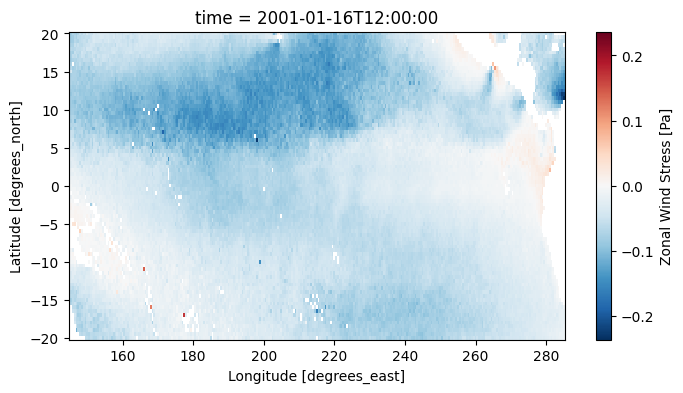

In [5]:
# plot the spatial pattern
plt.figure(figsize=(8,4))
taux.isel(time=0).plot()

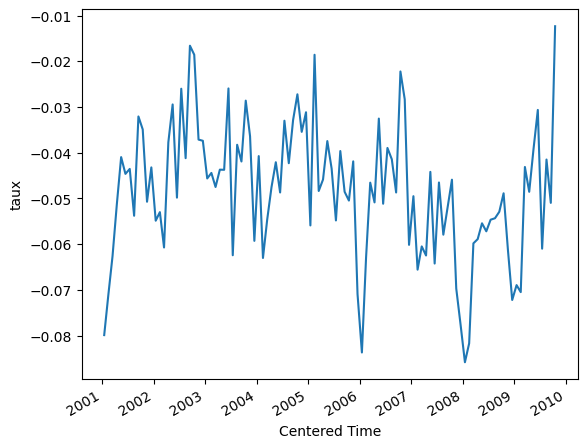

In [6]:
# plot a sample time series

# select grid point/region
eq_west = taux.sel(latitude=slice(-5,5), longitude=slice(180,200)).mean(['longitude', 'latitude'])

eq_west.plot()

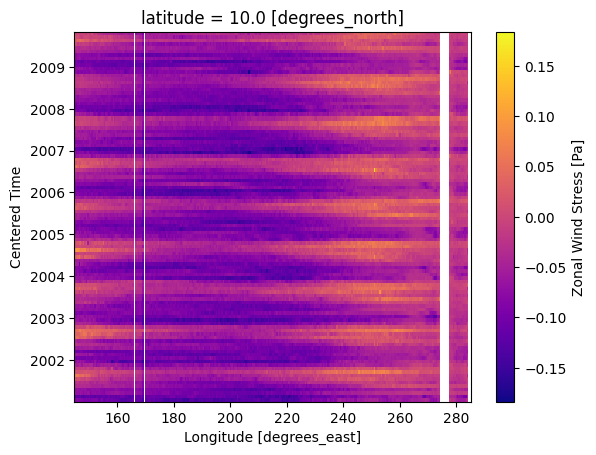

In [7]:
# hovmoller plot
taux.sel(latitude=10).plot(cmap='plasma')

### II. Replace the nan values

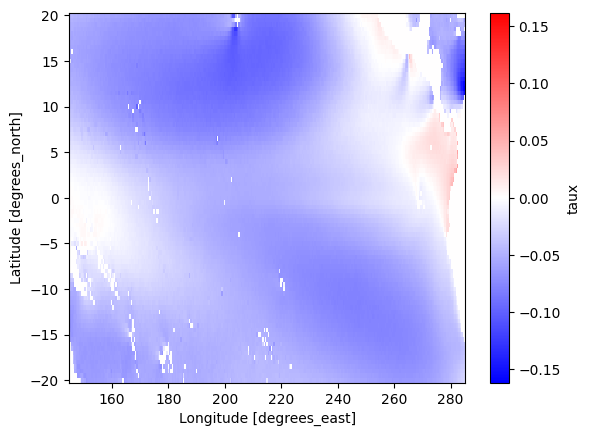

In [8]:
wind = taux.fillna(0)

# I also tried filling with i, infinity, True, or a string but either the svd couldn't converge or the data couldn't be plotted

#Check to see this has been done
wind.mean('time').plot(cmap='bwr')

#### Try to remove the Gulf of Mexico data

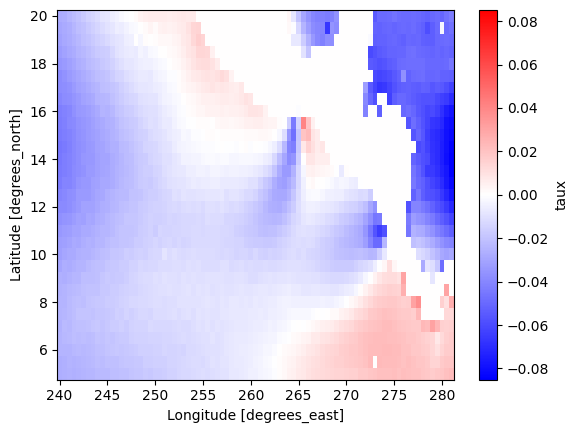

In [50]:
# from matplotlib import path
# p = path.Path([(0,0), (0, 1), (1, 1), (1, 0)])  # square with legs length 1 and bottom left corner at the origin
# p.contains_points([(.5, .5)])

#Check to see this has been done
wind.mean('time').sel(latitude=slice(5,20), longitude=slice(240,281)).plot(cmap='bwr')

triangle = np.array([[263,20], [280, 7], [280, 20]])



### III. Rearrange the data into a 2-D data matrix with dimensions space by time.

In [10]:
# find the length of the data's dimensions
t_len,lat_len,lon_len = data.taux.shape

# condense spatial coordinates into one dimension
wind2d = np.reshape(wind.values,((t_len,-1))) # t_len number of rows and however many columns
debug_print(wind2d.shape)

### IV. Remove the time mean from each time series

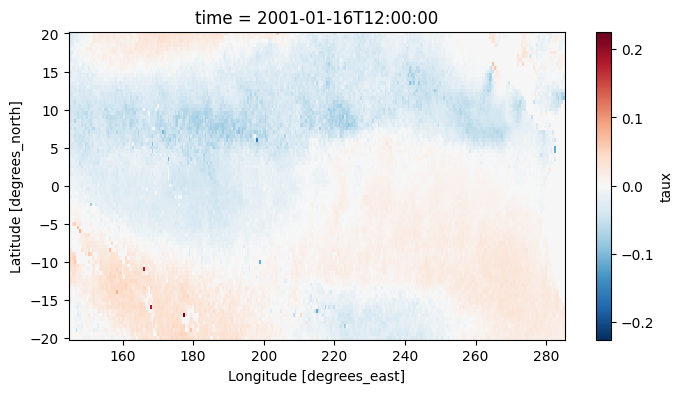

In [11]:
# Calculate the time mean
mean_wind = wind.mean('time')

# subtract the mean (to use covariances)
wind_anom = wind - mean_wind

# check 
plt.figure(figsize=(8,4))
wind_anom.isel(time=0).plot()

# reshape data using xarray stack to combine the spatial data
stacked = wind_anom.stack(space = ['latitude','longitude'])

# take the transpose so the data has the shape space x time ie each row is a time series for a particular point
wind2d = stacked.T
debug_print(wind2d)

### V. Compute the EOFs by Singular Value Decomposition (SVD).

U is of size MxM, corresponding to the M rows of the data matrix. When the data is organized where each row is the time series for a particular coordinate, M represents the number of spatial points and N is the number of time steps. Therefore, U would correspond to the spatial dimension and vT (size NxN) represents the mode time series.

In [13]:
# Calculate the SVD
u,s,vt = np.linalg.svd(stacked.T)
debug_print(u.shape)

# Select the spatial component, U, and reshape it to have 2D space with lat*lon modes
eof = np.reshape(u, (lat_len, lon_len, -1))
eof.shape

(81, 281, 22761)

##### Check the output

In [14]:
s

array([2.6110064e+01, 1.0655870e+01, 9.4049311e+00, 8.1731806e+00,
       6.8043904e+00, 6.3556890e+00, 5.6567798e+00, 5.4628243e+00,
       5.2624035e+00, 4.3762412e+00, 4.0916657e+00, 3.8962405e+00,
       3.5358207e+00, 3.3821964e+00, 3.3172824e+00, 3.0548215e+00,
       2.9398243e+00, 2.7648997e+00, 2.5686927e+00, 2.5348434e+00,
       2.4574828e+00, 2.3431628e+00, 2.3047826e+00, 2.1158049e+00,
       2.1083758e+00, 2.0468383e+00, 1.9609646e+00, 1.9396458e+00,
       1.8728135e+00, 1.7876550e+00, 1.7760409e+00, 1.7188967e+00,
       1.7073487e+00, 1.6745968e+00, 1.6507912e+00, 1.6276054e+00,
       1.6007125e+00, 1.5778115e+00, 1.5722082e+00, 1.5472564e+00,
       1.5079790e+00, 1.5013075e+00, 1.4893477e+00, 1.4567083e+00,
       1.4260949e+00, 1.4098302e+00, 1.4026084e+00, 1.3881108e+00,
       1.3705713e+00, 1.3553140e+00, 1.3382243e+00, 1.3304784e+00,
       1.3203143e+00, 1.3050214e+00, 1.2920834e+00, 1.2851291e+00,
       1.2751055e+00, 1.2580260e+00, 1.2518433e+00, 1.2499622e

In [15]:
u.shape

(22761, 22761)

In [16]:
s.shape

(105,)

In [17]:
vt.shape

(105, 105)

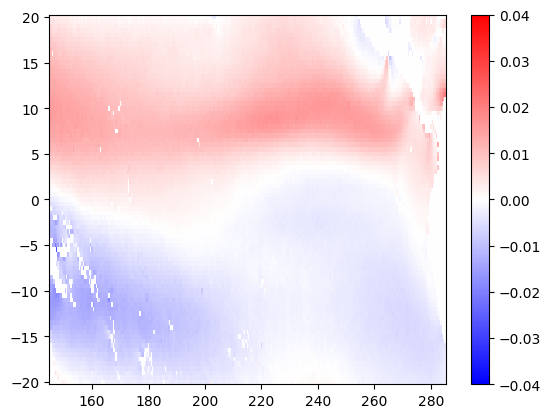

In [18]:
# Mode 1
ax=plt.pcolormesh(wind.longitude, wind.latitude, eof[:,:,0], cmap='bwr', vmin=-0.04, vmax=0.04)
plt.colorbar(ax)

### VI. For modes 1, 2 and 3, plot the spatial mode pattern and its associated time series.

In [19]:
# Create an Xarray DataArray for more convenient plotting
eof_xr = xr.DataArray(eof, 
coords=[data.latitude.values, data.longitude.values, range(lat_len*lon_len)], 
dims=["Latitude", "Longitude", "Mode"])
eof_xr

<xarray.DataArray (Latitude: 81, Longitude: 281, Mode: 22761)>
array([[[-9.9614878e-15,  4.4064094e-15, -8.3052454e-16, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 2.9981012e-16,  1.0595213e-16,  1.9419239e-17, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-3.2632987e-16, -4.7027629e-16, -1.5949752e-15, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [-2.9227557e-03, -1.8614143e-03, -2.7900450e-03, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-2.5122559e-03, -2.5959143e-03, -1.9157515e-03, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-2.5131269e-03, -1.9236014e-03, -1.5962255e-03, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
...
        [ 3.5565791e-03, -2.0939081e-04, -1.9710131e-03, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 4.4057709e-03, -1.5595941e-03, -4.7181719e-03, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 5.5891429e-03, -1.3286421e-03, -7.3701558e-03, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 3.1465208e-03,  4.4972245e-03, -8.9733228e-03, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.0682376e-03,  4.6727904e-03, -1.0515462e-02, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.4445690e-03,  5.0419532e-03, -1.1236831e-02, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  1.0000000e+00]]], dtype=float32)
Coordinates:
  * Latitude   (Latitude) float64 -20.0 -19.5 -19.0 -18.5 ... 19.0 19.5 20.0
  * Longitude  (Longitude) float64 145.0 145.5 146.0 146.5 ... 284.0 284.5 285.0
  * Mode       (Mode) int32 0 1 2 3 4 5 ... 22755 22756 22757 22758 22759 22760

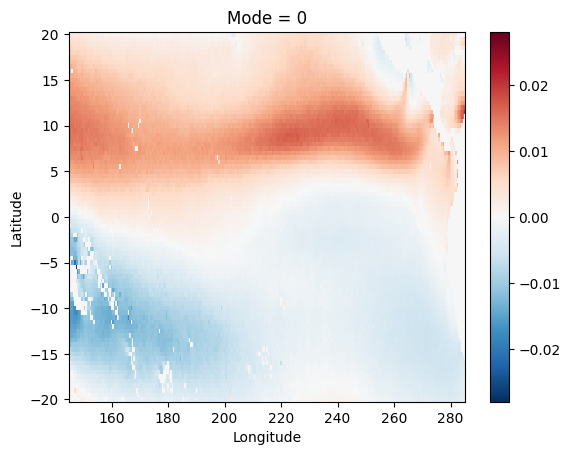

In [20]:
# Test if this equals the data above
# Mode 1
eof_xr.sel(Mode=0).plot()

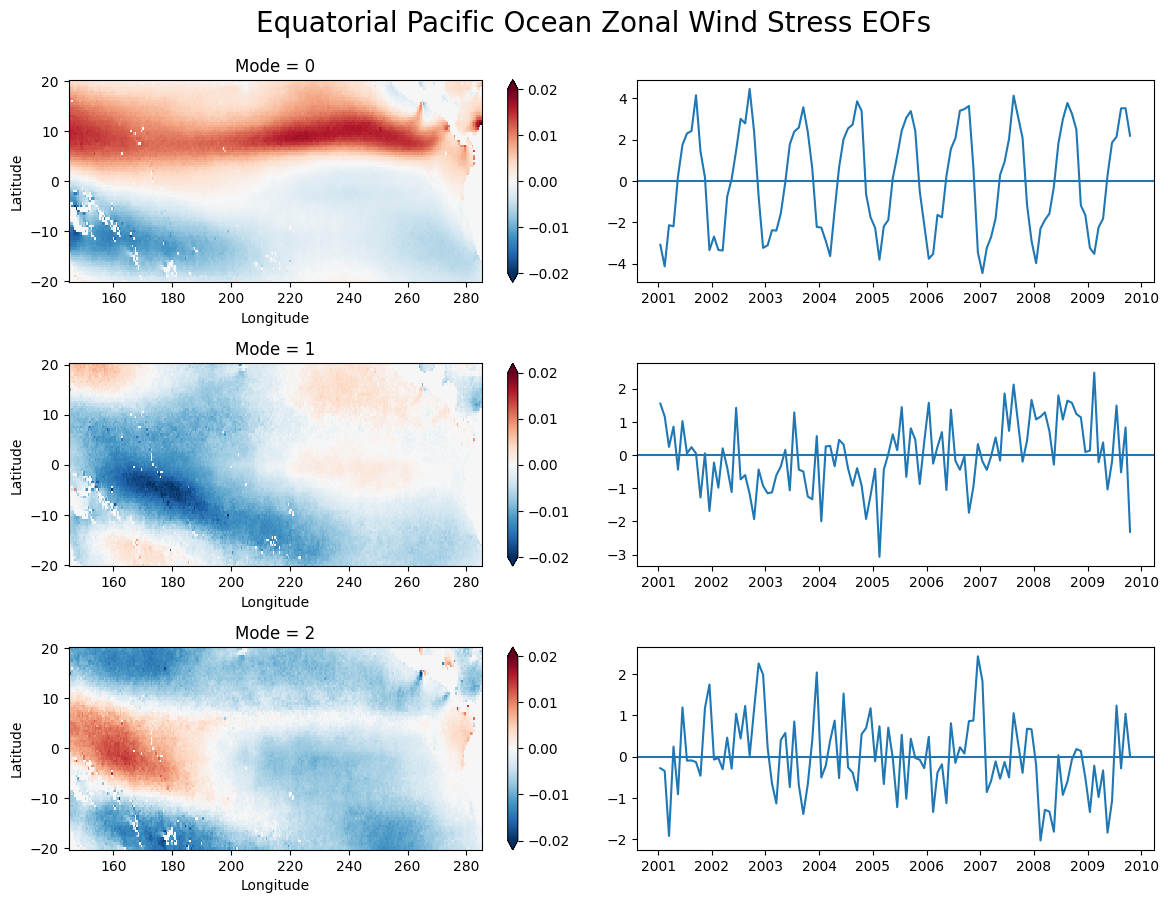

In [41]:
# Plot modes
lon = data.longitude
lat = data.latitude


f = plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.suptitle(f"Equatorial Pacific Ocean Zonal Wind Stress EOFs", fontsize=20, y=0.95)

# plot the first three modes and their time series'
for i in range(6):
    ax = plt.subplot(3, 2, i + 1)

    # print the maps in the even entries
    if i % 2 == 0:
        eof_xr.sel(Mode=i/2).plot(cmap='RdBu_r', vmin=-0.02, vmax=0.02, extend='both')
    
    # print the time series in odd entries
    # Select the principal component/time component, vT, times the units in the S matrix
    else:
        mode=[0,0,0,1,0,2]
        plt.plot(wind.time, vt[mode[i],:] * s[mode[i]])
        plt.axhline(y = 0)
    

### VII. Note and/or plot how much of the data variance is explained by each mode

The variance of the data when using SVD is given by the singular values, $\gamma$, (stored in S) squared. To find the fraction of the variance for each ith mode, we divide this by the total variance:
$$
\frac {\gamma_{i}^2} {\sum\limits_{j=1}^{M} \gamma_{j}^2}\
$$
In linear algebra terms, this is equivalent to SS<sup>T </sup> / trace(S)

Text(0.5, 0, 'Mode')

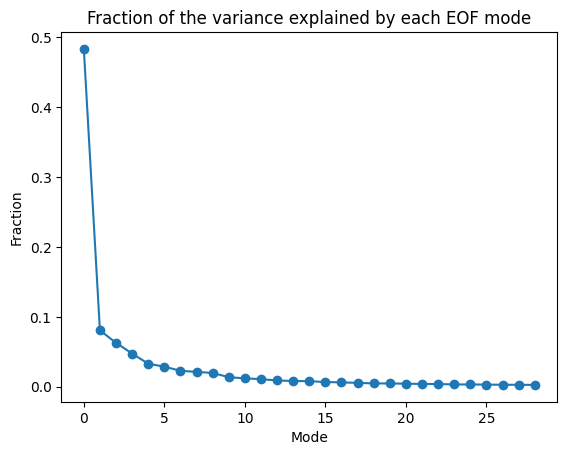

In [32]:
var = s**2
fraction = var / sum(var)

# select the first 20-30 modes since most are essentially zero
plt.plot(range(len(s[0:29])), fraction[0:29], marker='o')
plt.title('Fraction of the variance explained by each EOF mode')
plt.ylabel('Fraction')
plt.xlabel('Mode')

In the plot we can see that the fraction of the variance decrease with each mode. The first mode explains about 50% of the variance in the zonal wind stress, but the next leading mode drops to a little under 10%. The fractional variances approach 0 rather quickly. By 15 the values are already essentially zero (for the remaining 90 modes).

### VIII. Make some interpretation of the dynamics you observe in terms of El Nino, the seasonal cycle, or other climate variability processes

The first mode of variability appears to be the annual/seasonal cycle. The spatial EOF map shows that the zonal wind stresses in the northern and southern hemisphere are inversely correlated with a period of a year, as seen in the time series. This represents the seasonal differences between the hemispheres (NH winter = SH summer). The zonal wind stress will increase in the NH while decreasing in the SH and vice versa.

The next mode of variability appears to represent an El Nino, with decreased easterly wind stress in the western Pacific, and slight increases in the east. The time series is very noisy but there does appear to something like a sinusoidal curve, with a peak in 2001, a trough around 2003-2004 and another peak in 2008. If so, this period would be around 7 years. ENSO cycles tend to last 2-7 years with a similar spatial pattern. 

The third mode of variability looks like the reverse of the 2nd, representing a La Nina - with stregthened easterly wind stress in the western Pacific and weakened stress in the East. Like the spatial mode, the time series appears to the be the inverse of the 2nd mode. There is something of a peak around 2003-2004 and a trough around 2008-2009. This is a again a similar period as mode 2 which corresponds to that of ENSO.

Figure 1 of Capotondi and Ricciardulli (2021) (https://www.nature.com/articles/s41598-021-97963-4#Sec7) shows a similar EOF for zonal wind stress. Their first mode corresponds to our second mode and has a similar c-shaped blue region of decreased stress. They associate this pattern with ENSO, corroborating my analysis.

### IX. Even more extra credit: Test the significance of your modes